In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.linear import LinearExpr
import import_ipynb
import Methods as mt
%matplotlib inline

importing Jupyter notebook from Methods.ipynb


In [2]:
#Leitura das Instâncias
veiculos = pd.read_csv("k_30",index_col=0)
vitimas = pd.read_csv("v_10",index_col=0)
pontos = pd.read_csv("n_200",index_col=0)
hospitais = veiculos["Inicial"].unique()

In [3]:
#Criação da Matriz de Distância
_DistanceMatrix = pd.read_csv("d_200",index_col=0)

In [4]:
#Excluimos todas as distâncias referentes
#aos arcos não existentes
for i in _DistanceMatrix.index:
    for j in _DistanceMatrix.index:
        if j not in pontos.loc[i][2:].values:
            _DistanceMatrix.loc[i][j]=0

# Modelagem - VRP

In [5]:
vrp = Model("Ambulancias-VRP") #Modelo

In [6]:
#Matriz com as variáveis de decisão principais
_DecisionCube = vrp.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,veiculos.index,"Arc")

In [7]:
#Função Objetivo
vrp.minimize(vrp.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in veiculos.index))

In [8]:
forbidden = LinearExpr(vrp)   #Arcos proíbidos

for k in veiculos.index:
    for i in _DistanceMatrix.index:
        
        flux = LinearExpr(vrp)    #Conservação de Fluxo
        match = LinearExpr(vrp)   #Restrição de Compatibilidade
        for j in _DistanceMatrix.index:
            
            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe
                
                if i in vitimas["Ponto"].values:   #Se nodo 'i' for uma vítima:
                    match+=_DecisionCube[j,i,k]    #Adiciona os arcos 'jik' em 'match'
                    flux +=_DecisionCube[j,i,k]    #Subtrai o arco de chegada em 'i'
                    forbidden+=_DecisionCube[i,j,k]#A ambulância não pode um arco saindo de 'i'
                
                elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'
                
                elif j == veiculos.loc[k]["Inicial"]: #Se o nodo 'j' for o ponto de saida de 'k'
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução
                    flux -=_DecisionCube[j,i,k]       #Coloca o arco de saída de 'j' no fluxo
                    
                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal
                
                    
            else:                                #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução
                         
        if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))
            
            #Pega a prioridade da vitima 'i'
            prioridade = vitimas[vitimas["Ponto"] == i]["Prioridade"].values[0]
            
            #E cria as restriçõe de UpperBound
            vrp.add_constraint((veiculos.loc[k]["UpperBound"])*match-prioridade*match>=0,
                               "MatchUB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
            #E LowerBound
            vrp.add_constraint((veiculos.loc[k]["LowerBound"])*match-prioridade*match<=0,
                              "MatchLB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
       
        elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for o inicial do veiculo 'k'
            #Permite 'k' sair de 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp.add_constraint(forbidden==0,"Cuts");

In [9]:
for k in veiculos.index:
    
    inicial = veiculos.loc[k]["Inicial"] #Ponto de Saída de 'k'
    
    flux_inicial = LinearExpr(vrp) #Fluxo de Saída de 'k'
    
    for i in pontos.loc[inicial][2:].values:          #Para todos os arcos saindo do inicial
        flux_inicial+=_DecisionCube[inicial,int(i),k] #Adicione-os ao fluxo de saída
    
    flux_final = LinearExpr(vrp) #Fluxo de Chegada nas ocorrências
    
    for i in vitimas["Ponto"].values:          #Para todas as ocorrências
        for j in pontos.loc[i][2:]:            #Para todos os arcos saindo delas
            flux_final += _DecisionCube[j,i,k] #Adicione-os ao fluxo de chegada
            
    #Se o veículo sair de seu ponto inicial, ele deve atender uma ocorrência
    vrp.add_constraint(flux_inicial-flux_final==0,"AtendimentoObrigatorio_"+str(k))

In [10]:
for i in vitimas["Ponto"].values:
    
    demand = LinearExpr(vrp) #Demanda da vítima 'i'
    
    for j in pontos.loc[i][2:].values:
        for k in veiculos.index:
            #Para cada arco 'j' chegando em 'i' e veículo 'k'
            #Os adicionamos à expressão
            demand+=_DecisionCube[int(j),int(i),k]
    #Ao menos um precisa passar nessa vítima
    vrp.add_constraint(demand>=1,"DemandaVitima_"+str(i))

In [11]:
for k in veiculos.index:
    capacidade = LinearExpr(vrp) #Capacidade do veículo 'k'
    for i in vitimas["Ponto"].values:
        for j in pontos.loc[i][2:]:
            #Para cada arco chegando em cada vítima
            #Adicione-o à expressão
            capacidade+=_DecisionCube[int(j),int(i),k]
            
    #O veículo só pode 
    vrp.add_constraint(capacidade<=1,"CapacidadeVeiculo_"+str(k))

In [12]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:
    
    #Rota percorrida por cada veículo
    routes = {x:{} for x in veiculos.index}    
    
    #Solução VRP - Dicionário Desordenado
    _Solution = vrp.solve(log_output=True).as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave
    
    for i in _Solution:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo
       
    print(routes)
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada
    
    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in veiculos.index:
        
        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:
            
            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop
            
            inicial = veiculos.loc[k]["Inicial"]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)
            
            #inicial->actual_node = primeiro arco de todas as rotas
            
            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node not in vitimas["Ponto"].values:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)
                
                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...
        
        
        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])
        
        
        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:
            
            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                print(routes[k])
                cut = LinearExpr(vrp) #Expressão Linear do Subciclo atual
                
                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)
                
                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]
                
                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp.add_constraint(cut<=size,"SubCycleCut_"+str(count))
    
    if summ == 0:
        subcicle = False
print(time.time()-start)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 991 rows and 1295615 columns.
Reduced MIP has 6303 rows, 24385 columns, and 50312 nonzeros.
Reduced MIP has 24385 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.27 sec. (515.91 ticks)
Found incumbent of value 72669.975207 after 1.98 sec. (745.32 ticks)
Probing time = 0.05 sec. (2.29 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 6303 rows, 24385 columns, and 50312 nonzeros.
Reduced MIP has 24385 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.15 sec. (34.71 ticks)
Probing time = 0.04 sec. (2.70 ticks)
Clique table members: 66.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.54 sec. (222.74 ticks

0: 193 -> 0
3: 76 -> 71-> 23-> 1-> 85-> 198-> 159-> 182
4: 10 -> 195-> 31-> 150-> 16
6: 10 -> 195-> 31-> 96-> 29
8: 10 -> 195-> 31-> 150-> 181-> 141-> 118-> 166-> 12
17: 199 -> 17-> 22-> 174-> 63-> 169
18: 10 -> 56-> 55
20: 193 -> 32-> 111-> 58-> 135-> 40-> 82-> 69-> 190-> 116
22: 76 -> 70-> 50-> 107-> 90-> 132-> 72-> 45-> 28
27: 10 -> 56-> 151-> 148-> 113


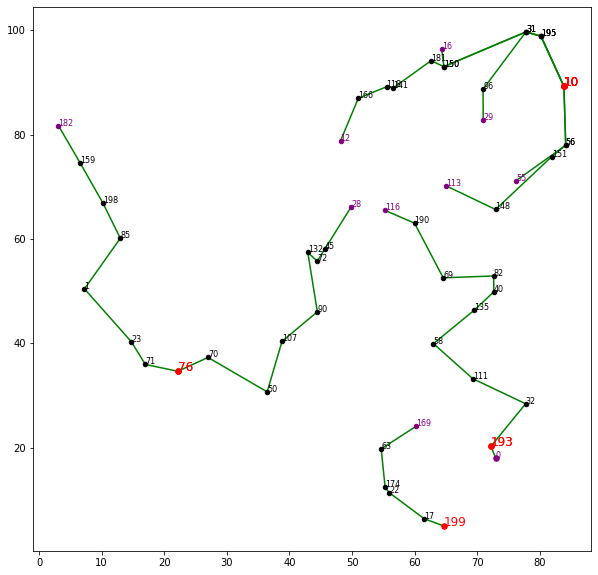

In [13]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        plt.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=30,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="purple")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                plt.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=8,color='purple')
            
        atendimentos[k] = actual_node
        print(string)
        
plt.show()

# Sinais

In [14]:
estado = pd.read_csv("s_200",index_col=0)

In [15]:
sinais = Model("Sinais")

In [16]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in pontos.index:
    for j in pontos.loc[i][2:]:
        #Somamos o tempo de cada arco
        sinal+=_DistanceMatrix.loc[i][int(j)]
sinal = (sinal/(3*len(pontos))) #O tempo de alteração vai ser a média

In [17]:
ordered_routes = mt.DecomposeRoute(_Solution,veiculos,vitimas) #Organiza os caminhos por ambulância

In [18]:
arc_count = mt.makeArcCount(ordered_routes,_DistanceMatrix)

In [19]:
maior_instante = 0
matriz_rotas={k:[] for k in atendimentos}
for k in atendimentos:
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    matriz,instante=mt.buildSets(_DistanceMatrix,ordered_routes[k],sinal,prioridade,pontos,estado,sinais_alterados=[],matriz_sinais=[])
    if instante>maior_instante:
        maior_instante=instante
    matriz_rotas[k] = matriz

In [20]:
same_instant={}

for arc in arc_count:
    same_instant[arc]={}
    instants={}
    for k in atendimentos:
        
        count = 0
        if arc in matriz_rotas[k][count]["sinais"].keys():
            instants[arc]=[]
            while count < len(matriz_rotas[k]):
                instant_k = matriz_rotas[k][count]["sinais"][arc][1]

                if instant_k not in instants[arc]:
                    instants[arc].append(instant_k)
                    same_instant[arc][instant_k]=[(k,count)]
                else:
                    same_instant[arc][instant_k].append((k,count))
                count+=1

In [21]:
config = {}
for k in atendimentos:
    count=0
    config[k]=[]
    for i in matriz_rotas[k]:
        config[k].append({"Config":sinais.binary_var("Config_"+str(count)+"_Carro_"+str(k)),"Peso":i["peso"]})
        count+=1

In [22]:
minimize=LinearExpr(sinais)
for k in atendimentos:
    choose1=LinearExpr(sinais)
    for i in config[k]:
        choose1+=i["Config"]
        minimize+=i["Config"]*i["Peso"]
    sinais.add_constraint(choose1==1,"Choose1ConfigVehicle"+str(k))
    
sinais.minimize(minimize)

In [23]:
for arc in same_instant:
    for time in same_instant[arc]:
        expressions={}
        for i in same_instant[arc][time]:
            vehicle = i[0]
            config_number = i[1]
            if i[0] not in expressions.keys():
                expr=LinearExpr(sinais)

                expr+=config[vehicle][config_number]["Config"]
                expressions[vehicle]=expr
            else:
                expressions[vehicle]+=config[vehicle][config_number]["Config"]

        consistent_timing=LinearExpr(sinais)
        count=0
        for k in expressions:
            if count==0:
                consistent_timing+=(len(expressions)-1)*expressions[k]
                count+=1
            else:
                consistent_timing-=expressions[k]
        sinais.add_constraint(consistent_timing==0,"ConsistentTimingArc_"+str(arc)+"_Time_"+str(time))

In [24]:
sinais.export_as_lp("ModeloSinais")

'ModeloSinais.lp'

In [25]:
_Solution2 = sinais.solve()

In [26]:
for i in _Solution2.as_dict():
    carro = i.split("_")[3]
    config = i.split("_")[1]
    print(str(carro)+" -> "+str(matriz_rotas[int(carro)][int(config)]["sinais"]))
    print("\n")

0 -> {(193, 0): (0, 0.2427515019813194)}


3 -> {(76, 71): (0, 0.5572669109572346), (71, 23): (0, 1.068973353915634), (23, 1): (0, 2.380603179391202), (1, 85): (0, 3.5550819069123225), (85, 198): (1, 5.320787960578538), (198, 159): (1, 7.194587754780849), (159, 182): (1, 9.029958538558555)}


4 -> {(10, 195): (0, 1.0733881621966754), (195, 31): (0, 1.3374143564967165), (31, 150): (0, 2.869893144423852), (150, 16): (0, 3.2214250762433)}


6 -> {(10, 195): (0, 1.0733881621966754), (195, 31): (0, 1.3374143564967165), (31, 96): (0, 2.686589844282917), (96, 29): (0, 3.2997402859651395)}


8 -> {(10, 195): (0, 1.0733881621966754), (195, 31): (0, 1.3374143564967165), (31, 150): (0, 2.869893144423852), (150, 181): (0, 3.1140841340389795), (181, 141): (0, 3.9417603907781316), (141, 118): (0, 4.059988681924028), (118, 166): (1, 5.58302915180289), (166, 12): (0, 6.48437240796429)}


17 -> {(199, 17): (0, 0.3637162295011491), (17, 22): (1, 2.14626234551372), (22, 174): (0, 2.2717734278968313), (17